## Deep Learning Approaches for RF-based detection & classification

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# import the torch packages
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU

from torch.nn import LogSoftmax
from torch import flatten
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

import torchvision.models as models

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn import svm

# import custom functions
from helper_functions import *
from latency_helpers import *
from loading_functions import *

from sklearn import preprocessing

from torchsummary import summary

### Load Features

In [2]:
feat_folder = '/home/ltindall/data/DroneDetect/Features/'
seg_len = 20
n_per_seg = 1024
interferences = ['WIFI']
output_name = 'drones' # 'drones', 'conds', 'ints'
feat_name = 'SPEC'
feat_format = 'IMG'
dataset = DroneDetectTorch(feat_folder, feat_name, seg_len, n_per_seg, feat_format,
                                output_name, interferences)
# dataset2 = load_dronedetect_data(feat_folder, feat_name, seg_len, n_per_seg, feat_format,
#                                 output_name, interferences)

In [3]:
# sub_folder_name = feat_format+'_'+feat_name+'_'+str(n_per_seg)+'_'+str(seg_len)+'/'

#     augmented_int = aug_int(interferences) # map interference names to codes
# files = os.listdir(feat_folder+sub_folder_name)

In [4]:
print('dataset size', len(dataset))
print('shape of each item', dataset.__getitem__(4)[0].shape)

dataset size 10000
shape of each item (224, 224, 3)


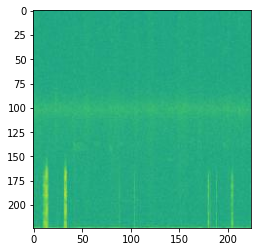

In [5]:
d = dataset.__getitem__(4)[0]
plt.imshow(d)
plt.show()


In [6]:
# cv2.imshow('img',dataset.__getitem__(10)[0].numpy()/255.)

# cv2.waitKey()

In [7]:
## Transfer learning from Resnet50 & Apply Logistic Regression (Swinney paper)

In [8]:
# use pretrained resnet feature and just keep up to the last layer
# resnet50 = models.resnet50(pretrained=True)
# modules=list(resnet50.children())[:-1]
# # resnet50=nn.Sequential(*modules)
# for p in resnet50.parameters():
#     p.requires_grad = False

In [9]:
# test resnet
# input = torch.randn(1,1,30,300)
# inputr = input.repeat(1,3,1,1)
# resnet50(inputr).shape

In [10]:
# resnet_feats = []
# resnet_y = []
# for n in range(len(dataset)):
#     d = dataset.__getitem__(n)
#     inarr = d[0]
#     inputr = inarr.repeat(1,3,1,1)  # repeat to have 3 channels of the same info
#     out = resnet50(inputr)
#     resnet_feats.append(np.array(out))
#     resnet_y.append(np.array(d[1]))

# resnet_feats = np.array(resnet_feats)
# resnet_y = np.array(resnet_y)

# # flatten the middle dimension
# resnet_feats = resnet_feats.reshape(resnet_feats.shape[0], resnet_feats.shape[-1])
# # invert labels back to categorical
# resnet_y_cat = dataset.le.inverse_transform(resnet_y.astype(np.int64))

## Transfer learning VGG16

In [15]:
vgg16 = models.vgg16()
# summary(vgg16, (3,224,224))

modules=list(vgg16.children())[:-1]
vggfeats=nn.Sequential(*modules)

for p in vggfeats.parameters():
    p.requires_grad = False

In [17]:
# test one input
d = dataset.__getitem__(0)
inarr = d[0]
# print(inarr.shape)
# premove = inarr[:,:,0]
inarr = torch.tensor(inarr).float()
inarr = torch.moveaxis(inarr, 2, 0)
# print(inarr.shape)
# postmove = inarr[0]
# print(premove==postmove) # confirm it is the same channel

# WHEN using single channel array format
# inputr = inarr.repeat(1,3,1,1)
# inputr = inputr.to(device)
out = vggfeats(inarr)

# reshape the output
out.flatten()

tensor([0.0105, 0.0097, 0.0087,  ..., 0.0472, 0.0422, 0.0278])

In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vggfeats = vggfeats.to(device) #set model to device

TEST_vgg_feats = []
TEST_vgg_y = []
for n in tqdm(range(len(dataset))):
    d = dataset.__getitem__(n)
    inarr = d[0]
#     inputr = inarr.repeat(1,3,1,1)  # repeat to have 3 channels of the same info
    inarr = torch.tensor(inarr).float().to(device)
    inputr = torch.moveaxis(inarr, 2, 0) # move axis to have channels come first
    inputr = inputr.to(device)
    out = vggfeats(inputr)
    
    TEST_vgg_feats.append(out.cpu().numpy().flatten())
    TEST_vgg_y.append(np.array(d[1]))

vgg_feats = np.array(TEST_vgg_feats)
vgg_y = np.array(TEST_vgg_y)

# flatten the middle dimension
vgg_feats = vgg_feats.reshape(vgg_feats.shape[0], vgg_feats.shape[-1])
# invert labels back to categorical
#vgg_y_cat = dataset.le.inverse_transform(vgg_y.astype(np.int64))
vgg_y_cat = np.array([dataset.idx_to_class[i] for i in vgg_y])

100%|██████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:35<00:00, 280.27it/s]


In [31]:
# Save VGG features
vgg_save = {'feats': vgg_feats, 'y_cat':vgg_y_cat, 'y':vgg_y}
file_name = 'VggFeats_'+str(seg_len)+'_'+str(n_per_seg)+'correct_psd_img_normalized'
np.save(file_name, vgg_save)

In [22]:
a = np.load('VggFeats_'+str(seg_len)+'_'+str(n_per_seg)+'correct_psd_img.npy', allow_pickle=True)

In [24]:
a.item()

{'feats': array([[2.490401  , 2.262325  , 2.4863806 , ..., 1.4792047 , 1.3382037 ,
         0.21188897],
        [2.4258134 , 2.1341937 , 2.2895484 , ..., 3.6967764 , 2.5883462 ,
         0.        ],
        [2.394059  , 2.469457  , 2.66085   , ..., 1.4873842 , 1.6475986 ,
         0.72833884],
        ...,
        [2.3744721 , 2.5082047 , 2.585939  , ..., 3.8416758 , 1.7907357 ,
         0.05835885],
        [2.4425294 , 1.8136778 , 1.9712423 , ..., 0.8470199 , 1.2261016 ,
         0.14727461],
        [2.4376254 , 2.868694  , 2.9528666 , ..., 1.4207358 , 1.1715617 ,
         0.49170136]], dtype=float32),
 'y_cat': array(['PHA', 'AIR', 'INS', ..., 'MIN', 'DIS', 'MP2'], dtype='<U3'),
 'y': array([6, 0, 2, ..., 3, 1, 5])}

In [25]:
vgg_y

array([6, 0, 2, ..., 3, 1, 5])

In [26]:
dataset.idx_to_class = {i:lbl for i,lbl in enumerate(dataset.unique_labels)}

### Run Logistic Regression

In [36]:
feats_lr = vgg_feats # which features to use for logit reg
y_cat = vgg_y_cat
print(feats_lr.shape)

(10000, 25088)


In [39]:
# choose a subset of data for faster hyperparameter search
import random
n_choose = 2000
ichoose = random.sample(range(0, feats_lr.shape[0]), n_choose)

feats_lr_small = feats_lr[ichoose]
y_cat_small = y_cat[ichoose]

In [40]:
# visualize the spectrograms
# import matplotlib.cm as cm

# spec = d[0]

# fig = plt.figure(figsize=(6,6))
# plt.pcolormesh(spec, cmap='hot')
# plt.show()
# ax = fig.add_subplot(111, projection='3d')
# n_f, n_t = spec.shape
# t = np.linspace(0,n_t,n_t)
# f = np.linspace(0,n_f,n_f)
# t_2d, f_2d = np.meshgrid(t,f)
# ax.plot_surface(t_2d, f_2d, spec)

# ax.plot_surface(t_2d, f_2d, feats_lr, cmap=cm.jet)
# ax.set_zlim(-0,2)

In [41]:
# split data into K-fold
k_fold = 5
cv = KFold(n_splits=k_fold, random_state=1, shuffle=True)

# model parameters
Cs=list(map(lambda x:pow(2,x),range(-2,10,5)))

best_params_ls = []
acc_ls = []
f1_ls = []
runt_ls = []

parameters = {'C':Cs}

for train_ix, test_ix in tqdm(cv.split(feats_lr_small)):
    
    # find the optimal hypber parameters
    lr = LogisticRegression()
    clf = GridSearchCV(lr, parameters, n_jobs=1)
    clf.fit(feats_lr_small[train_ix], y_cat_small[train_ix])
    
    print(clf.best_params_)
    best_params_ls.append(clf.best_params_)
    
    # predict on the test data
    y_pred, runtimes = atomic_benchmark_estimator(clf, feats_lr_small[test_ix], output_type= '<U3', 
                                                  verbose=False)
    runt_ls.append(np.mean(runtimes))
    
    acc = accuracy_score(y_cat_small[test_ix], y_pred)
    f1 = f1_score(y_cat_small[test_ix], y_pred, average='weighted')
    print('Accuracy: {:.3},\t F1: {:.3}'.format(acc,f1))
    acc_ls.append(acc)
    f1_ls.append(f1)
    
out_msg = feat_name+': ResNet+LR average test acc: {:.2}, F1: {:.2}, Run-time: {:.2}ms'.format(np.mean(acc_ls), np.mean(f1_ls), np.mean(runt_ls)*1e3)
print(out_msg)

0it [00:00, ?it/s]/home/ltindall/.pyenv/versions/3.10.4/envs/RFClassification/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ltindall/.pyenv/versions/3.10.4/envs/RFClassification/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternati

{'C': 8}
Accuracy: 0.618,	 F1: 0.62


/home/ltindall/.pyenv/versions/3.10.4/envs/RFClassification/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ltindall/.pyenv/versions/3.10.4/envs/RFClassification/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:

{'C': 8}
Accuracy: 0.68,	 F1: 0.683


/home/ltindall/.pyenv/versions/3.10.4/envs/RFClassification/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ltindall/.pyenv/versions/3.10.4/envs/RFClassification/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:

{'C': 256}
Accuracy: 0.637,	 F1: 0.636


/home/ltindall/.pyenv/versions/3.10.4/envs/RFClassification/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ltindall/.pyenv/versions/3.10.4/envs/RFClassification/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:

{'C': 256}
Accuracy: 0.637,	 F1: 0.637


/home/ltindall/.pyenv/versions/3.10.4/envs/RFClassification/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ltindall/.pyenv/versions/3.10.4/envs/RFClassification/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:

{'C': 256}
Accuracy: 0.635,	 F1: 0.635
SPEC: ResNet+LR average test acc: 0.64, F1: 0.64, Run-time: 0.2ms


In [ ]:
### FIXED PARAMETER LOGISTIC REGRESSION ###
k_fold = 5
cv = KFold(n_splits=k_fold, random_state=10, shuffle=True)

Xs_arr = feats_lr
y_arr = vgg_y

best_params_ls = []
score_ls = []

for train_ix, test_ix in cv.split(Xs_arr):
    
    # find the optimal hypber parameters
    clf = LogisticRegression(C =8, class_weight = 'balanced',n_jobs=-1)
#     clf = svm.SVC(kernel='rbf', C=512, gamma = 0.5)
    clf.fit(Xs_arr[train_ix], y_arr[train_ix])
    
    # predict on the test data
    y_pred = clf.predict(Xs_arr[test_ix])
    acc = accuracy_score(y_arr[test_ix], y_pred)
    print(acc)
    score_ls.append(acc)
    
print('VGG feats+LR K-fold average test score:', np.mean(score_ls))


In [ ]:
y_cat

## Run kNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
# neigh = KNeighborsClassifier(n_neighbors=3)

In [ ]:
## Fixed parameter kNN
k_fold = 5
cv = KFold(n_splits=k_fold, random_state=10, shuffle=True)

Ns=list(range(2,100,10))
parameters = {'n_neighbors':Ns}

Xs_arr = feats_lr
y_arr = y_cat

best_params_ls = []
score_ls = []

for train_ix, test_ix in cv.split(Xs_arr):
    
    # find the optimal hypber parameters
    neigh = KNeighborsClassifier()
    clf = GridSearchCV(neigh, parameters, n_jobs=1)
    clf.fit(Xs_arr[train_ix], y_arr[train_ix])
    
    # predict on the test data
    y_pred = clf.predict(Xs_arr[test_ix])
    acc = accuracy_score(y_arr[test_ix], y_pred)
    print(acc)
    score_ls.append(acc)
    
print('VGG feats+kNN K-fold average test score:', np.mean(score_ls))

## 3. Apply resnet & a fully connected layer

In [ ]:
# # Define network
# model = torch.hub.load('pytorch/vision:v0.6.0', 'vgg19', pretrained=True)
# model.classifier = nn.Linear(model.classifier[0].in_features, num_classes)
# print(model)

In [ ]:
class ResnetFC(nn.Module):
    def __init__(self, num_classes):
        super(ResnetFC,self).__init__()
        self.num_classes = num_classes
        self.resnetfull = models.resnet50(pretrained=True)
        modules=list(self.resnetfull.children())[:-2] # remove the fully connected layer & adaptive averaging
        self.resnetfeats=nn.Sequential(*modules)
        
        for param in self.resnetfeats.parameters():
            self.resnetfeats.requires_grad_(False)
        
        self._fc = nn.Linear(1505280, num_classes)
    def forward(self, x):
#         batch_size ,_,_ =x.shape
        
        # replicate the image to have 3 channels
        x = x.repeat(1,3,1,1)
        print(x.shape)
        x = self.resnetfeats(x)
        x = x.flatten()
        print(x.shape)
        x = self._fc(x)
        
        return x

In [ ]:
fctest = ResnetFC(7)

In [ ]:
test_input = dataset.__getitem__(10)[0]
print(test_input.shape)

In [ ]:
# Test an input
test_input = dataset.__getitem__(10)[0]
# test_input = torch.rand(1, 129, 4687)


test_input = test_input.unsqueeze(axis=0)
print(test_input.shape)
fctest.forward(test_input)

In [ ]:
fctest.resnetfeats.cuda()
FULLRES = models.resnet50(pretrained=True)
FULLRES = FULLRES.cuda()
summary(FULLRES, (3,224,224))

In [ ]:
print(list(FULLRES.children()))

### Kfold CV

In [ ]:
from nn_functions import runkfoldcv

In [ ]:
# Configuration options
k_folds = 2

batch_size = 8 # 128
num_classes = 7
learning_rate = 0.01
num_epochs = 1 # 0
momentum = 0.95
l2reg = 1e-4

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
runkfoldcv(fctest, dataset, device, k_folds, batch_size, learning_rate, num_epochs, momentum, l2reg)